<a href="https://colab.research.google.com/github/Sonlowami/SM-Extremism/blob/main/MBDA_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Extremism Detection Challenge

In [1]:
!pip install -q -U krippendorff wordcloud

In [2]:
import numpy as np
import pandas as pd
import krippendorff
from itertools import combinations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


#A. Quantitative Analysis

In [3]:
!gdown --id 1mzOPHeii_me8VuBNoo6BDVlxLNj9zXIM -O extremism_data_final.csv
!gdown --id 1RETEMjmBma38HlRZuuB9NLjwvXJCRhu4 -O mbd_annotation_sample_30.csv

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mzOPHeii_me8VuBNoo6BDVlxLNj9zXIM
To: /content/extremism_data_final.csv
100% 388k/388k [00:00<00:00, 6.27MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RETEMjmBma38HlRZuuB9NLjwvXJCRhu4
To: /content/mbd_annotation_sample_30.csv
100% 5.71k/5.71k [00:00<00:00, 14.5MB/s]


In [4]:
# load the data
df = pd.read_csv("./extremism_data_final.csv")

## Dataset Statistics

  - Assess dataset shape, size, class counts, and percentage distribution
  - Check for duplicates and missing values (drop/impute with justification)
  - Text characteristics: add text_length, word_count, avg_word_length columns
  - Compare statistics for the new columns between classes
  - Visualizations: Bar Chart (class distribution), Histograms (text characteristics)

In [5]:
print(f"Dataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nColumn Names: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
df.head()

Dataset Shape: (2777, 2)
Number of rows: 2777
Number of columns: 2

Column Names: ['Original_Message', 'Extremism_Label']

Data Types:
Original_Message    object
Extremism_Label     object
dtype: object

First 5 rows:


,Original_Message,Extremism_Label
0,sixth forms should burn to the ground,EXTREMIST
1,whatever should burn benders to the ground,EXTREMIST
2,factories should burn to the ground,EXTREMIST
3,halal factories should burn to the ground,EXTREMIST
4,nhs should burn to the ground,EXTREMIST


**Observation:** The dataset contains **2,777 rows** and **2 columns** (`Original_Message` and `Extremism_Label`). Both columns are of string type, which is expected for a text classification task. The structure is straightforward: one feature column (the post text) and one target label column.


In [6]:
class_counts = df['Extremism_Label'].value_counts()
class_pct = df['Extremism_Label'].value_counts(normalize=True) * 100

print("=== Class Distribution ===")
print(f"\nClass Counts:\n{class_counts}")
print(f"\nPercentage Distribution:\n{class_pct.round(2)}")
print(f"\nTotal samples: {len(df)}")

=== Class Distribution ===

Class Counts:
Extremism_Label
NON_EXTREMIST    1454
EXTREMIST        1323
Name: count, dtype: int64

Percentage Distribution:
Extremism_Label
NON_EXTREMIST    52.36
EXTREMIST        47.64
Name: proportion, dtype: float64

Total samples: 2777


**Observation:** The dataset is **fairly balanced**. NON_EXTREMIST posts account for **52.36%** (1,454 samples) while EXTREMIST posts account for **47.64%** (1,323 samples). The gap is only about 4.7%, which means we do not need to apply resampling techniques such as SMOTE or undersampling to address class imbalance. This balance is favorable for training an unbiased classifier.


In [7]:
full_duplicates = df.duplicated().sum()
text_duplicates = df.duplicated(subset=['Original_Message']).sum()

print("=== Duplicate Analysis ===")
print(f"Full row duplicates: {full_duplicates}")
print(f"Text-only duplicates: {text_duplicates}")

if full_duplicates > 0 or text_duplicates > 0:
    print(f"\nDropping {text_duplicates} text duplicates...")
    df = df.drop_duplicates(subset=['Original_Message'], keep='first')
    print(f"Dataset size after dropping duplicates: {df.shape[0]}")
    print("\nJustification: Duplicates are dropped to prevent data leakage and bias.")
    print("Keeping duplicate texts would inflate the importance of repeated samples")
    print("and could lead to overfitting if the same text appears in train and test sets.")
else:
    print("\nNo duplicates found. The dataset is clean in this regard.")

=== Duplicate Analysis ===
Full row duplicates: 0
Text-only duplicates: 0

No duplicates found. The dataset is clean in this regard.


**Observation:** **No duplicates** were found, neither full-row duplicates nor text-only duplicates. Every post in the dataset is unique, so there is no risk of data leakage from duplicate texts appearing in both training and test splits.


In [8]:
print("=== Missing Values Analysis ===")
print(f"\nMissing values per column:\n{df.isnull().sum()}")
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Show the missing rows
missing_text = df[df['Original_Message'].isnull()]
if len(missing_text) > 0:
    print(f"\nRows with missing text ({len(missing_text)} found):")
    print(missing_text)

    # Drop rows with missing text
    df = df.dropna(subset=['Original_Message'])
    print(f"\nDataset size after handling missing values: {df.shape[0]}")
else:
    print("\nNo missing values found!")

# Confirm clean dataset
print(f"\n=== Clean Dataset Summary ===")
print(f"Final shape: {df.shape}")
print(f"Final class distribution:\n{df['Extremism_Label'].value_counts()}")

=== Missing Values Analysis ===

Missing values per column:
Original_Message    1
Extremism_Label     0
dtype: int64

Total missing values: 1

Rows with missing text (1 found):
     Original_Message Extremism_Label
1228              NaN   NON_EXTREMIST

Dataset size after handling missing values: 2776

=== Clean Dataset Summary ===
Final shape: (2776, 2)
Final class distribution:
Extremism_Label
NON_EXTREMIST    1453
EXTREMIST        1323
Name: count, dtype: int64


**Observation:** Only **1 missing value** was found at index 1228 (row 1230 in Excel), where the `Original_Message` is empty but labeled as NON_EXTREMIST. This row was **dropped** rather than imputed.

**Justification for deletion:** The text column is our only input feature, so there is no meaningful way to impute or generate a social media post that does not exist. Filling it with an empty string or a placeholder like "unknown" would only introduce noise into the model. Since only 1 out of 2,777 rows is affected (**≈0.04%** of the data), the impact on dataset size is negligible. The cleaned dataset now has **2,776 rows**.

In [9]:
df['text_length'] = df['Original_Message'].str.len()
df['word_count'] = df['Original_Message'].str.split().str.len()
df['avg_word_length'] = df['text_length'] / df['word_count']

print("=== New Columns Added ===")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample of new columns:")
df[['Original_Message', 'text_length', 'word_count', 'avg_word_length']].head(10)

=== New Columns Added ===

Columns: ['Original_Message', 'Extremism_Label', 'text_length', 'word_count', 'avg_word_length']

Sample of new columns:


,Original_Message,text_length,word_count,avg_word_length
0,sixth forms should burn to the ground,37,7,5.285714
1,whatever should burn benders to the ground,42,7,6.000000
2,factories should burn to the ground,35,6,5.833333
3,halal factories should burn to the ground,41,7,5.857143
4,nhs should burn to the ground,29,6,4.833333
5,nhs should burn to the ground because it is fu...,62,12,5.166667
6,around the world you will find a number of peo...,79,16,4.937500
7,around the world you will find a number of peo...,96,19,5.052632
8,around the world you will find a number of peo...,103,20,5.150000
9,the malala fund is trash let us shoot the stup...,55,11,5.000000


**Observation:** Three new feature columns have been successfully added to the dataset:
- `text_length`: Total number of characters in each post
- `word_count`: Total number of words in each post
- `avg_word_length`: Average number of characters per word (text_length / word_count)

These columns allow us to quantitatively compare the structural properties of EXTREMIST vs NON_EXTREMIST posts.

In [10]:
print("=== Text Characteristics: Overall Statistics ===\n")
print(df[['text_length', 'word_count', 'avg_word_length']].describe().round(2))

=== Text Characteristics: Overall Statistics ===

       text_length  word_count  avg_word_length
count      2776.00     2776.00          2776.00
mean        126.62       23.29             5.44
std         104.56       19.20             0.96
min           8.00        2.00             3.33
25%          66.00       12.75             4.76
50%          99.00       19.00             5.26
75%         156.00       29.00             5.90
max        1379.00      281.00            12.00


In [11]:
print("\n\n=== Text Characteristics: By Class ===\n")
class_stats = df.groupby('Extremism_Label')[['text_length', 'word_count', 'avg_word_length']].describe().round(2)
class_stats



=== Text Characteristics: By Class ===



text_length                                                    \
                      count    mean     std   min   25%    50%    75%     max   
Extremism_Label                                                                 
EXTREMIST            1323.0  134.56  128.85  10.0  62.0   93.0  188.0  1379.0   
NON_EXTREMIST        1453.0  119.39   75.30   8.0  70.0  103.0  143.0   743.0   

                word_count         ...              avg_word_length        \
                     count   mean  ...   75%    max           count  mean   
Extremism_Label                    ...                                      
EXTREMIST           1323.0  24.50  ...  31.0  281.0          1323.0  5.47   
NON_EXTREMIST       1453.0  22.19  ...  28.0  138.0          1453.0  5.41   

                                                      
                  std   min   25%   50%   75%    max  
Extremism_Label                                       
EXTREMIST        0.93  3.57  4.78  5.35  5.96  11.81  
NON_EXTREMIST    0.99  3.33  4.75  5.20  5.83  12.00  

[2 rows x 24 columns]

In [12]:
# Side-by-side mean comparison
print("\n\n=== Mean Comparison ===")
mean_comparison = df.groupby('Extremism_Label')[['text_length', 'word_count', 'avg_word_length']].mean().round(2)
print(mean_comparison)



=== Mean Comparison ===
                 text_length  word_count  avg_word_length
Extremism_Label                                          
EXTREMIST             134.56       24.50             5.47
NON_EXTREMIST         119.39       22.19             5.41


In [13]:
# Mean difference between classes
extremist_means = df[df["Extremism_Label"] == "EXTREMIST"][["text_length", "word_count", "avg_word_length"]].mean()
non_extremist_means = df[df["Extremism_Label"] == "NON_EXTREMIST"][["text_length", "word_count", "avg_word_length"]].mean()
difference = extremist_means - non_extremist_means

comparison = pd.DataFrame({
    "EXTREMIST": extremist_means.round(2),
    "NON_EXTREMIST": non_extremist_means.round(2),
    "Difference": difference.round(2)
})
print("=== Class Comparison: Mean Differences ===")
print()

=== Class Comparison: Mean Differences ===



**Observation:** Comparing the mean text characteristics between classes:

| Metric | EXTREMIST | NON_EXTREMIST | Difference |
|--------|-----------|---------------|------------|
| Text Length | 134.56 chars | 119.39 chars | **+15.17** |
| Word Count | 24.50 words | 22.19 words | **+2.31** |
| Avg Word Length | 5.47 chars | 5.41 chars | **+0.06** |

**Key Insights:**
- EXTREMIST posts are on average **15 characters longer** and use about **2 more words** than NON_EXTREMIST posts.
- The average word length difference is negligible (**+0.06 chars**), meaning vocabulary complexity is nearly identical across both classes.
- This tells us that **post length alone is not a reliable feature** for classification. The model will need to learn actual linguistic patterns and word-level content to distinguish between the two classes.

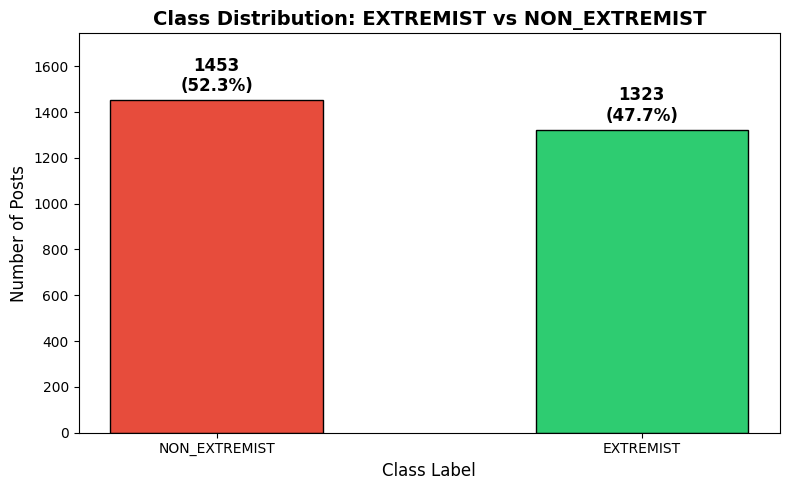

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = ['#e74c3c', '#2ecc71']  # red for extremist, green for non-extremist
class_counts = df['Extremism_Label'].value_counts()

bars = ax.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', width=0.5)

# Add count labels on bars
for bar, count, pct in zip(bars, class_counts.values, (class_counts / len(df) * 100)):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 20,
            f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_title('Class Distribution: EXTREMIST vs NON_EXTREMIST', fontsize=14, fontweight='bold')
ax.set_xlabel('Class Label', fontsize=12)
ax.set_ylabel('Number of Posts', fontsize=12)
ax.set_ylim(0, max(class_counts.values) * 1.2)
plt.tight_layout()
plt.show()

**Observation:** The bar chart confirms a **near-balanced distribution** between the two classes. NON_EXTREMIST (52.3%) holds a slight majority over EXTREMIST (47.7%), but the difference is minimal. This visual representation supports our earlier statistical finding that no class rebalancing is required.


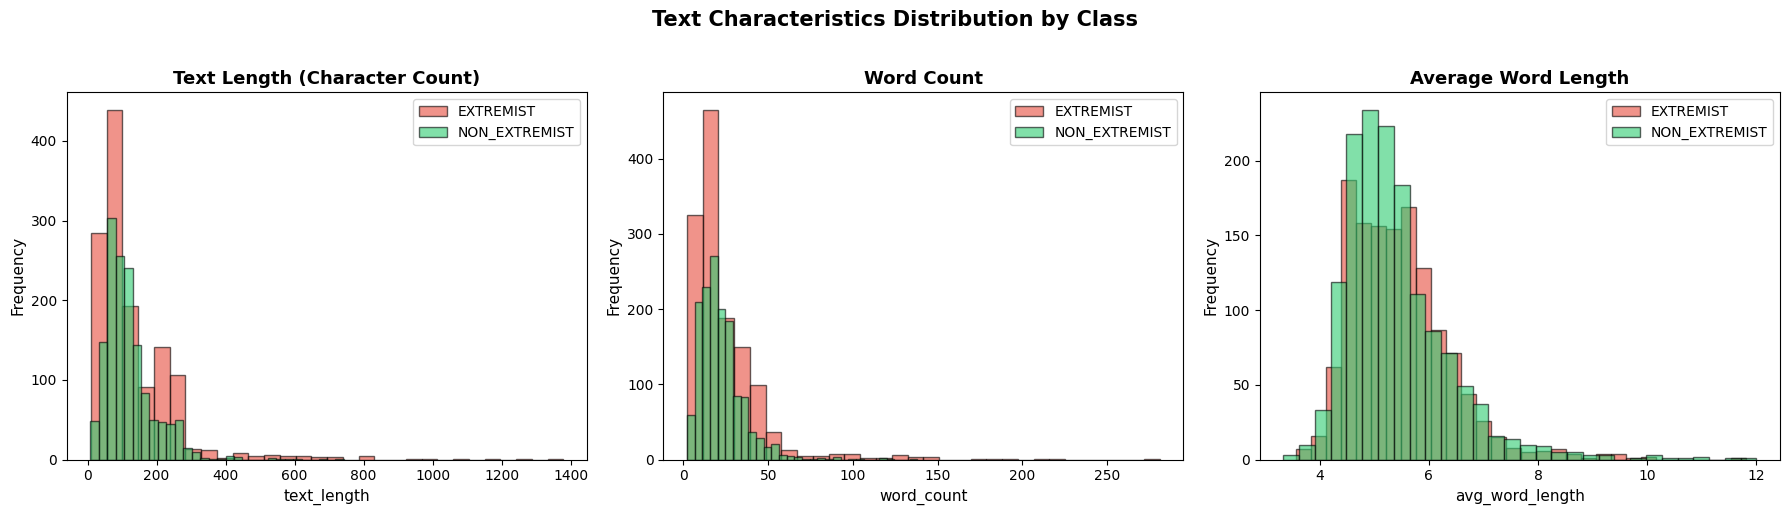

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

features = ['text_length', 'word_count', 'avg_word_length']
titles = ['Text Length (Character Count)', 'Word Count', 'Average Word Length']
colors_map = {'EXTREMIST': '#e74c3c', 'NON_EXTREMIST': '#2ecc71'}

for idx, (feature, title) in enumerate(zip(features, titles)):
    ax = axes[idx]
    for label, color in colors_map.items():
        subset = df[df['Extremism_Label'] == label][feature]
        ax.hist(subset, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend()

plt.suptitle('Text Characteristics Distribution by Class', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Observation:** The histograms reveal the following patterns:

1. **Text Length and Word Count:** Both classes show **right-skewed distributions**. The majority of posts are short (under 200 characters / 30 words), with a long tail of outliers extending to around 1,400 characters / 280 words. The distributions overlap heavily, confirming that post length is not a strong differentiator between classes.

2. **Average Word Length:** Both classes follow a roughly **normal distribution** centered around 5 to 6 characters per word, with nearly identical shapes. This confirms that vocabulary complexity is comparable across both classes.

**Conclusion:** The structural characteristics (length, word count, word complexity) of EXTREMIST and NON_EXTREMIST posts are very similar. Effective classification will therefore depend on **content-level features**, specifically the actual words and phrases used, rather than surface-level text statistics. This motivates the use of TF-IDF vectorization in the ML Baseline Model (Section C).

## Linguistic Analysis

      - Find the top 20 most occurying words
      - Find the top 20 most occurying words in the extremist posts
      - Find the top 20 most occurying words in the non-extremist posts
      - Plot the word clouds for the extreme and non-extremist posts

In [16]:
words = df['Original_Message'].str.split(expand=True).stack()
top20 = words.value_counts().head(20)
xtreme = df[df['Extremism_Label']=='EXTREMIST']['Original_Message'].str.split(expand=True).stack()
unxtreme = df[df['Extremism_Label']=='NON_EXTREMIST']['Original_Message'].str.split(expand=True).stack()

In [17]:
def display_counts(counts, title):
  print(title)
  print("_" * 40)

  # Convert the Series to a list of lists for tabulate
  table_data = [[word, count] for word, count in counts.items()]

  print(tabulate(table_data, headers=["Word", "Frequency"], tablefmt="fancy"))

In [18]:
display_counts(top20, "Top 20 Frequent Words")

Top 20 Frequent Words
________________________________________
Word      Frequency
------  -----------
the            1802
a              1623
to             1589
you            1558
and            1350
of             1257
i              1166
is              959
are             922
bitch           832
not             809
in              708
that            677
it              663
with            628
they            557
all             530
kill            503
for             442
do              437


In [19]:
display_counts(xtreme.value_counts().head(20), "Top 20 Frequent Words in Extremist Posts")

Top 20 Frequent Words in Extremist Posts
________________________________________
Word      Frequency
------  -----------
the             899
to              840
and             786
of              688
you             677
a               636
are             588
i               548
is              471
kill            425
not             405
they            401
it              396
all             390
in              375
with            349
that            316
them            283
us              222
get             220


In [20]:
display_counts(unxtreme.value_counts().head(20), "Top 20 Frequent Words in non Extremist Posts")

Top 20 Frequent Words in non Extremist Posts
________________________________________
Word       Frequency
-------  -----------
a                987
the              903
you              881
to               749
bitch            730
i                618
of               569
and              564
is               488
not              404
that             361
are              334
in               333
with             279
it               267
for              237
my               234
do               231
fucking          229
trump            228


In both cases, there is a low-value english words like 'is', 'the', 'in', 'are', and others. To get a better feel for words that are relevant in extremist and non-extremist context, we can use a word cloud for each of the classes.

As seen in the word cloud below, words like **kill** and **let** are associated with extremism while words like **bitch** and **fucking** are associated with non-extremism. This is surprising because the words highly associated with non-extremism are themselves vulgar. Moreover, if a user uses one of these words in an hate post, the weight given to them might sway classification models into misclassifying the message.

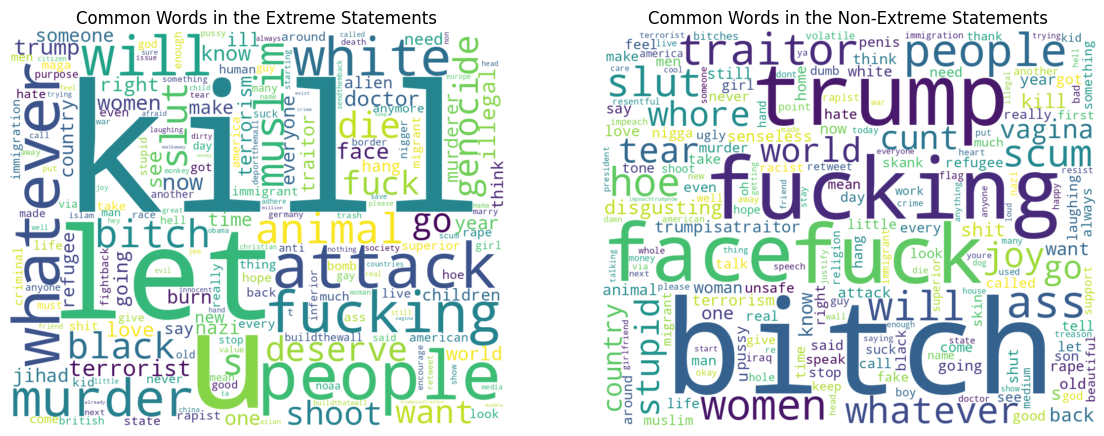

In [21]:
# word clouds for the extremist posts
text = " ".join(xtreme.values)
xtreme_cloud = WordCloud(width=1000, height=800, background_color='white', collocations=False).generate(text)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
ax[0].imshow(xtreme_cloud, interpolation='bilinear')
ax[0].set_title("Common Words in the Extreme Statements")
ax[0].axis('off')

# word clouds for the non-extremist posts
text = " ".join(unxtreme.values)
unxtreme_cloud = WordCloud(width=1000, height=800, background_color='white', collocations=False).generate(text)
ax[1].imshow(unxtreme_cloud, interpolation='bilinear')
ax[1].set_title("Common Words in the Non-Extreme Statements")
plt.axis('off')
plt.show()


# B. Qualitative Analysis

# Randomly sampling 30 examples for annotations

In [22]:
# Load your dataset
df_original = pd.read_csv('./extremism_data_final.csv')

# Sampling according to labels
class_extremist = df_original[df_original['Extremism_Label'] == 'EXTREMIST'].sample(n=15, random_state=42)
class_non_extremist = df_original[df_original['Extremism_Label'] == 'NON_EXTREMIST'].sample(n=15, random_state=42)

# Combine both samples
sample_df = pd.concat([class_extremist , class_non_extremist])

# Shuffle the final combined dataset
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Add ID column
sample_df.insert(0, 'ID', range(1, len(sample_df) + 1))

# Save to CSV
sample_df.to_csv('df_sample_30.csv', index=False)

print("Sampling completed and file saved as df_sample_30.csv.csv")

Sampling completed and file saved as df_sample_30.csv.csv


# Inter-Rater Reliability(IRR) Analysis

In [23]:
# ===============================
# 1. Load Annotated Dataset
# ===============================

df_annotated = pd.read_csv("mbd_annotation_sample_30.csv")

annotator_columns = [
    "Extremism_Label",
    "Group_member1",
    "Group_member2",
    "Group_member3",
    "Group_member4",
    "Group_member5"
]

# Remove rows with missing annotations
df_annotated = df_annotated.dropna(subset=annotator_columns)

# Converting labels to numeric as they are categorical
for col in annotator_columns:
    df_annotated[col] = df_annotated[col].astype("category").cat.codes


# ===============================
# 2. Percentage Agreement
# ===============================

def pairwise_agreement(df, col1, col2):
    agreements = (df[col1] == df[col2]).sum()
    total = len(df)
    return round(agreements / total, 3)

agreement_results = []

for col1, col2 in combinations(annotator_columns, 2):
    score = pairwise_agreement(df_annotated, col1, col2)
    agreement_results.append({
        "Rater_1": col1,
        "Rater_2": col2,
        "Percent_Agreement": score * 100
    })

agreement_df = pd.DataFrame(agreement_results)


# ===============================
# 3. Pairwise Krippendorff Alpha
# ===============================

def compute_pairwise_alpha(df, columns, level="nominal"):
    results = []

    for col1, col2 in combinations(columns, 2):
        pair_data = [
            df[col1].tolist(),
            df[col2].tolist()
        ]

        alpha = krippendorff.alpha(
            reliability_data=pair_data,
            level_of_measurement=level
        )

        results.append({
            "Rater_1": col1,
            "Rater_2": col2,
            "Krippendorff_Alpha": round(alpha, 3)
        })

    return pd.DataFrame(results)

alpha_df = compute_pairwise_alpha(df_annotated, annotator_columns, level="nominal")

# ===============================
# 4. Save Results
# ===============================

agreement_df.to_csv("pairwise_percentage_agreement.csv", index=False)
alpha_df.to_csv("pairwise_krippendorff_alpha.csv", index=False)

print("\nIRR analysis completed and results saved.")



IRR analysis completed and results saved.


# Disagreement Analysis

In [24]:
# ===============================
# Disagreement Analysis
# ===============================

human_annotators = [
    "Group_member1",
    "Group_member2",
    "Group_member3",
    "Group_member4",
    "Group_member5"
]

# Count unique labels per row
df_annotated["unique_labels"] = df_annotated[human_annotators].nunique(axis=1)

# Mark disagreements
df_annotated["disagreement"] = df_annotated["unique_labels"] > 1

# Extract disagreement examples
disagreement_examples = df_annotated[df_annotated["disagreement"] == True]

# Calculate disagreement rate
total_examples = len(df_annotated)
num_disagreements = df_annotated["disagreement"].sum()
disagreement_rate = round(num_disagreements / total_examples, 3)

print("\n===== Disagreement Analysis =====")
print(f"Total Examples: {total_examples}")
print(f"Disagreement Examples: {num_disagreements}")
print(f"Inter-Human Disagreement Rate: {disagreement_rate}")


===== Disagreement Analysis =====
Total Examples: 30
Disagreement Examples: 24
Inter-Human Disagreement Rate: 0.8


# Examples that had the most inter-human disagreement for our group's sample set

In [25]:
#Compute Disagreement Score

def disagreement_strength(row):
    counts = row[human_annotators].value_counts()
    majority_count = counts.max()
    total = len(human_annotators)
    return 1 - (majority_count / total)

df_annotated["disagreement_strength"] = df_annotated.apply(disagreement_strength, axis=1)


max_strength = df_annotated["disagreement_strength"].max()

strong_disagreement = df_annotated[df_annotated["disagreement_strength"] == max_strength]
print("Number of examples with highest disagreement:", len(strong_disagreement))
print("\nExamples with strongest disagreement (3 vs 2 splits):")
strong_disagreement


Number of examples with highest disagreement: 10

Examples with strongest disagreement (3 vs 2 splits):


,ID,Original_Message,Extremism_Label,Group_member1,Group_member2,Group_member3,Group_member4,Group_member5,unique_labels,disagreement,disagreement_strength
0,1,she isnt racist unlike your somalia bitch frie...,1,0,1,1,1,0,2,True,0.4
1,2,if i ever saw kendall jones in person i d kill...,1,0,0,1,1,0,2,True,0.4
3,4,i am in iraq as whatever speak your country is...,1,1,0,0,1,0,2,True,0.4
6,7,disabled people artfully the fucking scum of t...,1,0,1,1,0,0,2,True,0.4
7,8,if your fiance has a conversation with a bitch...,1,0,0,0,1,1,2,True,0.4
13,14,whatever do not blow up our wives and children...,0,0,1,1,1,0,2,True,0.4
14,15,never a doubt that our founders saw the writin...,0,1,1,0,1,0,2,True,0.4
20,21,in my opinion whatever should be afraid of the...,1,0,0,1,1,1,2,True,0.4
23,24,keyshia key whore is a bird gucci should have ...,1,0,0,0,1,1,2,True,0.4
25,26,ceasefire let s see how long those towel heads...,0,1,1,0,0,0,2,True,0.4


# How often did the majority of annotators agree with the original label

In [26]:
#Compute Majority Vote
df_annotated["majority_vote"] = df_annotated[human_annotators].mode(axis=1)[0]

#Compare Majority With Original Label
df_annotated["majority_matches_original"] = (
    df_annotated["majority_vote"] == df_annotated["Extremism_Label"]
)

#Calculate Agreement Rate
agreement_count = df_annotated["majority_matches_original"].sum()

total_examples = len(df_annotated)

agreement_rate = round(agreement_count / total_examples, 3)

print("Majority agreement count:", agreement_count)
print("Total examples:", total_examples)
print("Majority vs Original Agreement Rate:", agreement_rate)


Majority agreement count: 16
Total examples: 30
Majority vs Original Agreement Rate: 0.533


# Where our group disagreed with original labels

In [27]:
group_disagreements = df_annotated[df_annotated["majority_matches_original"] == False]

print("\n===== Examples Where Group Disagreed With Original Label =====\n")
group_disagreements[[
    "ID",
    "Original_Message",
    "Extremism_Label",
    "majority_vote"
]]



===== Examples Where Group Disagreed With Original Label =====



,ID,Original_Message,Extremism_Label,majority_vote
1,2,if i ever saw kendall jones in person i d kill...,1,0
3,4,i am in iraq as whatever speak your country is...,1,0
6,7,disabled people artfully the fucking scum of t...,1,0
7,8,if your fiance has a conversation with a bitch...,1,0
9,10,yet calling president trump and republicans na...,0,1
12,13,leader and i use that word entirely wrongly cl...,0,1
13,14,whatever do not blow up our wives and children...,0,1
14,15,never a doubt that our founders saw the writin...,0,1
16,17,jihadi john is a terrorist,0,1
17,18,i really sympathize for the kid at do not care...,0,1


In [28]:
group_disagreements[[
    "ID",
    "Original_Message",
    "Extremism_Label",
    "majority_vote"
]].to_csv("group_disagreements.csv", index=False)

# C. ML Baseline Model

## Define Features and Labels

In [29]:
X = df['Original_Message'] # Independent variable
y = df['Extremism_Label'] # Dependent variable

## Stratified Train / Validation / Test Split (70/15/15)

In [30]:
# Split the dataset into training (70%), 30% sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Further split the 30% set into validation (15%) and test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 1943
Validation set size: 416
Test set size: 417


In [31]:
# check class balance
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation class distribution:\n", y_val.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 Extremism_Label
NON_EXTREMIST    0.523417
EXTREMIST        0.476583
Name: proportion, dtype: float64

Validation class distribution:
 Extremism_Label
NON_EXTREMIST    0.524038
EXTREMIST        0.475962
Name: proportion, dtype: float64

Test class distribution:
 Extremism_Label
NON_EXTREMIST    0.522782
EXTREMIST        0.477218
Name: proportion, dtype: float64


Observation: The dataset is nearly balanced, across training, validation, and test sets. This means class imbalance is minimal, metrics like accuracy and F1 are reliable, and stratified splits have preserved class proportions. Using `class_weight="balanced"` is a safe precaution, but the model can already learn both classes effectively.


## TF-IDF Vectorization (Default Parameters Only)

In [32]:
# Initialize TF-IDF Vectorizer (default parameters)
vectorizer = TfidfVectorizer()

# Fit on training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform validation and test
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Check feature size
print("Number of features:", X_train_tfidf.shape[1])

Number of features: 6028


## Train Logistic Regression (Default Parameters)

In [33]:
# Initialize Logistic Regression model with default parameters
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train_tfidf, y_train)

LogisticRegression()

## Evaluate on Validation Set

In [34]:
# Predict on validation set
y_val_pred = model.predict(X_val_tfidf)

# Classification Report
print("Classification Report (Validation Set):\n")
print(classification_report(y_val, y_val_pred))

Classification Report (Validation Set):

               precision    recall  f1-score   support

    EXTREMIST       0.83      0.79      0.81       198
NON_EXTREMIST       0.81      0.85      0.83       218

     accuracy                           0.82       416
    macro avg       0.82      0.82      0.82       416
 weighted avg       0.82      0.82      0.82       416



Observation:

* **EXTREMIST:** Precision 0.83, recall 0.79, F1-score 0.81. The model predicts EXTREMIST correctly most of the time but misses about 21% of extremist samples.
* **NON_EXTREMIST:** Precision 0.81, recall 0.85, F1-score 0.83. The model identifies non-extremist samples slightly better than extremist ones.
* **Overall accuracy:** 0.82, with macro and weighted F1 both at 0.82, indicating balanced performance across classes.

**Interpretation:**
The model is performing reasonably well, but EXTREMIST recall is slightly lower than NON_EXTREMIST, meaning some extremist content is being missed.


## Confusion Matrix

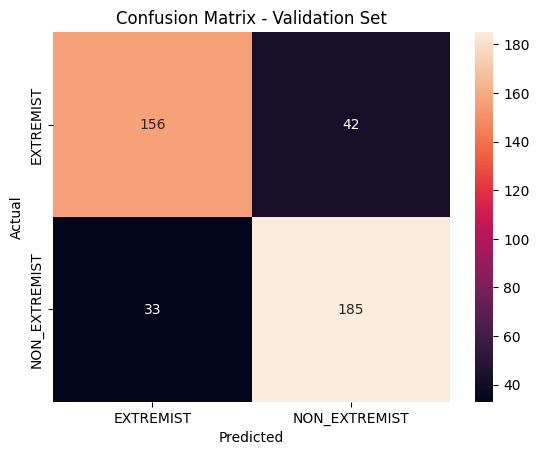

In [35]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=model.classes_,
            yticklabels=model.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

Observation:
* **EXTREMIST class:** 156 correctly predicted, 42 misclassified as NON_EXTREMIST.
* **NON_EXTREMIST class:** 185 correctly predicted, 33 misclassified as EXTREMIST.

## Save Validation Errors (Needed for Part D)

In [36]:
# Create a DataFrame to analyze misclassifications
val_results = pd.DataFrame({
    "text": X_val,
    "true_label": y_val,
    "predicted_label": y_val_pred
})

# All misclassifications
errors = val_results[val_results["true_label"] != val_results["predicted_label"]]

# False Positives
false_positives = val_results[
    (val_results["true_label"] == "NON_EXTREMIST") & (val_results["predicted_label"] == "EXTREMIST")
]

# False Negatives
false_negatives = val_results[
    (val_results["true_label"] == "EXTREMIST") & (val_results["predicted_label"] == "NON_EXTREMIST")
]

print("Total misclassifications:", len(errors))
print("False Positives:", len(false_positives))
print("False Negatives:", len(false_negatives))

# Add error type column for manual review
errors = errors.copy()
errors["error_type"] = errors.apply(
    lambda r: "FP" if (r.true_label == "NON_EXTREMIST" and r.predicted_label == "EXTREMIST") else "FN",
    axis=1
)

# Save to CSV
errors.to_csv("errors_validation_10.csv", index=False)

Total misclassifications: 75
False Positives: 33
False Negatives: 42


# D. Required Error Analysis

##  Suggested Improvements

### 1. TF-IDF + LinearSVC with Raw Term Frequency and Bigram Features


**Description:**
This approach combines **TF-IDF vectorization** using **unigrams and bigrams** (`ngram_range=(1,2)`) with **raw term frequencies** (`sublinear_tf=False`) and feeds the resulting high-dimensional sparse features into a **Linear Support Vector Classifier** (`LinearSVC`). The `class_weight="balanced"` ensures that minority classes, like EXTREMIST, are given proportionally more importance. This setup captures both the presence and intensity of words and short phrases, enabling better separation of classes in text classification tasks, particularly when repeated or structured expressions carry meaningful signals.

In [37]:
from sklearn.svm import LinearSVC

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),       # Include unigrams and bigrams
    min_df=2,                # Only include terms that appear in at least 2 documents
    max_df=0.95,             # Ignore terms that appear in more than 95% of documents
    sublinear_tf=False       # Use raw term frequencies instead of sublinear scaling
)

# Fit on training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform validation and test
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Check feature size
print("Number of features:", X_train_tfidf.shape[1])

model = LinearSVC(class_weight="balanced")
model.fit(X_train_tfidf, y_train)

Number of features: 6960


LinearSVC(class_weight='balanced')

In [38]:
# Predictions
y_val_pred = model.predict(X_val_tfidf)

# Classification Report
print("Classification Report (Validation Set):\n")
print(classification_report(y_val, y_val_pred))

Classification Report (Validation Set):

               precision    recall  f1-score   support

    EXTREMIST       0.82      0.85      0.84       198
NON_EXTREMIST       0.86      0.83      0.85       218

     accuracy                           0.84       416
    macro avg       0.84      0.84      0.84       416
 weighted avg       0.84      0.84      0.84       416



**Overall Accuracy:** This improved from 82% to 84%, a modest but meaningful 2-point gain on the same validation set.

**EXTREMIST class:** This is where the most interesting shift happened. Before, precision was slightly higher (0.83 vs 0.82 after), but recall was to 0.79. This means the pre-adjustment model was *missing* more actual extremist content, catching only 79% of true positives versus 85% now. For a content safety use case, this is the most critical improvement. The F1 reflects this: 0.81 → 0.84.

**NON_EXTREMIST class:** The direction flips here. Before adjustments, recall was higher (0.85 vs 0.83 after), meaning the old model was more conservative, more inclined to label things as non-extremist. After adjustments, precision improved (0.81 → 0.86), so when the model clears something as non-extremist, it's more confident in that call.

**The core trade-off:** The adjustments essentially shifted the model's decision boundary — it became more aggressive at catching extremist content (higher extremist recall) at the cost of slightly more false positives on that class (lower extremist precision) and slightly fewer non-extremist recalls.

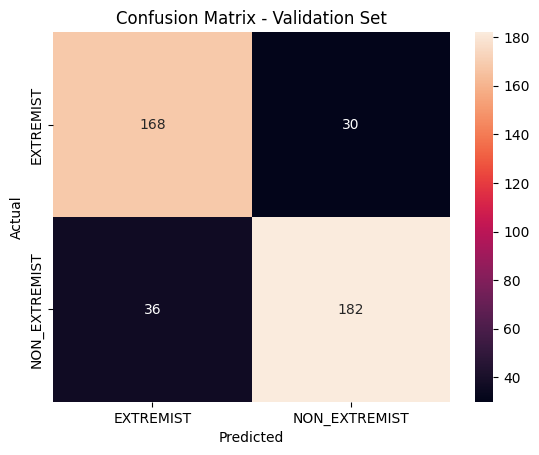

In [39]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=model.classes_,
            yticklabels=model.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

Observation:
* **EXTREMIST class:** 168 correctly predicted, 30 misclassified as NON_EXTREMIST.
* **NON_EXTREMIST class:** 182 correctly predicted, 36 misclassified as EXTREMIST.

In [40]:
val_results = pd.DataFrame({
    "text": X_val,
    "true_label": y_val,
    "predicted_label": y_val_pred
})

# All misclassifications
errors = val_results[val_results["true_label"] != val_results["predicted_label"]]

# False Positives
false_positives = val_results[
    (val_results["true_label"] == "NON_EXTREMIST") & (val_results["predicted_label"] == "EXTREMIST")
]

# False Negatives
false_negatives = val_results[
    (val_results["true_label"] == "EXTREMIST") & (val_results["predicted_label"] == "NON_EXTREMIST")
]

print("Total misclassifications:", len(errors))
print("False Positives:", len(false_positives))
print("False Negatives:", len(false_negatives))

Total misclassifications: 66
False Positives: 36
False Negatives: 30
